## Structure factor

Some of useful information regarding the structure factor is presented as below:

 - https://en.wikipedia.org/wiki/Structure_factor
 - https://jscatter.readthedocs.io/en/latest/structurefactor.html
 - https://pure.mpg.de/rest/items/item_2055745/component/file_2055744/content
 - https://scipython.com/book/chapter-6-numpy/additional-problems/structure-factors-for-perfect-crystals/
 
In this simple tutorial, I approach in two different directions to calculate the structure factor $S(q)$: (1) By directly calculate $S(q)=\frac{1}{N} \sum_j^N \sum_k^N e^{-iq(R_j-R_k)}$. Or instead of calculating the intensity, I calculate a complex function $\psi(q)=\sum_j^N e^{-iqR_j}$ (called scattering wavefunction) and calculate the strucuture factor by $\frac{1}{N} \psi(q)\psi^*(q)$. (2) By using the Fast Fourier Transformation (FFT) algorithm, on a real space mesh grid. 

I personally favor the FFT approach (since it's quite convinient and numerically neat). Also, because I need to calculate the structure factor of the deuterium local density $n(r)$, it's more reliable to use the FFT library to Fourier transform the density (which is numerical data).  

In [1]:
import ase
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.fft import fftn, ifftn
import matplotlib.cm as cm
from numpy import linalg as LA
from tqdm import tqdm_notebook
from tqdm.notebook import trange,tqdm
from ase.io import read, write
from ase.neighborlist import build_neighbor_list, natural_cutoffs
from ase.build import make_supercell

## FFT routine

### BCC crystal (unit-cell)

We consider a BCC crystal of iron (Fe) of the lattice constant 2.87 Angstrom.

### FCC

In [56]:
alat=2.87
hkl=4
N=51
pos_bcc=np.zeros((N,N,N))

# atoms at (0,0,0) and (a/2,a/2,a/2)
pos_bcc[0,0,0]=1.0
pos_bcc[N-1,0,0]=1.0
pos_bcc[0,N-1,0]=1.0
pos_bcc[N-1,N-1,0]=1.0
pos_bcc[int(N/2),int(N/2),0]=1.0

pos_bcc[int(N/2),0,int(N/2)]=1.0
pos_bcc[0,int(N/2),int(N/2)]=1.0
pos_bcc[int(N/2),N-1,int(N/2)]=1.0
pos_bcc[N-1,int(N/2),int(N/2)]=1.0

pos_bcc[0,0,N-1]=1.0
pos_bcc[N-1,0,N-1]=1.0
pos_bcc[0,N-1,N-1]=1.0
pos_bcc[N-1,N-1,N-1]=1.0
pos_bcc[int(N/2),int(N/2),N-1]=1.0

#Fourier transform
Sq_bcc=fftn(pos_bcc)
Sq_bcc=np.absolute(Sq_bcc)

In [70]:
Sq_bcc[1,2,1]

5.901703615153458

Expand the fourier function to larger $k$-space for the analysis. In this example, we make $(6 \times 6 \times 6)$ supercell ($hkl=6$). Keep in mind that the Fourier transformed function is still periodic in $k$-space. 

In [17]:
Sq_bcc_hkl=np.zeros((hkl*Sq_bcc.shape[0],hkl*Sq_bcc.shape[1],hkl*Sq_bcc.shape[2]))

for i in range(hkl):
    for j in range(hkl):
        for k in range(hkl):
            Sq_bcc_hkl[i*Sq_bcc.shape[0]:(i+1)*Sq_bcc.shape[0],
                       j*Sq_bcc.shape[1]:(j+1)*Sq_bcc.shape[1],
                       k*Sq_bcc.shape[2]:(k+1)*Sq_bcc.shape[2]] = Sq_bcc

We see that the Fourier transformed wavefunction in $k_x$ direction has a sinusoidal shape.

ValueError: x and y must have same first dimension, but have shapes (51,) and (1,)

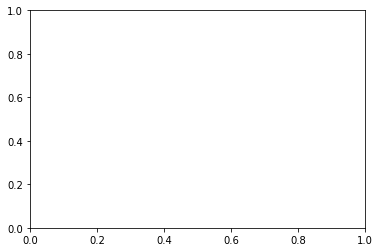

In [63]:
plt.plot(range(N),Sq_bcc[25,25,25])

We then project the 3 dimensional $S(q)$ function to a one-dimensional $S(|q|)$ which is a function of the modulus of $|q|$. Please keep in mind that the projection is radial (need to divide a factor $\frac{4}{3}\pi(r^3_{i+1}-r^3_i)$).

In [19]:
Iq_bcc=[]
for i in trange(N*hkl-1):
    for j in range(N*hkl-1):
        for k in range(N*hkl-1):
            r0=(2*np.pi/alat)*np.sqrt(
              ( ((i)/N)**2 + ((j)/N)**2 + ((k)/N)**2 )
            )
            r1=(2*np.pi/alat)*np.sqrt(
              ( ((i+1)/N)**2 + ((j)/N)**2 + ((k)/N)**2 )
            )
            Iq_bcc.append([
                           r0, 
                           Sq_bcc_hkl[i,j,k]/(r1**3-r0**3)
                          ])
Iq_bcc=np.asarray(Iq_bcc)

In [20]:
q=(2*np.pi/alat)*np.arange(0.0,(2*np.pi/alat)*hkl*np.sqrt(3),0.01)

Iq=np.zeros(q.shape[0])
for i in trange(Iq_bcc.shape[0]):
    Iq[np.abs(q-Iq_bcc[i,0]).argmin()]+=Iq_bcc[i,1]

### Plot FFC case

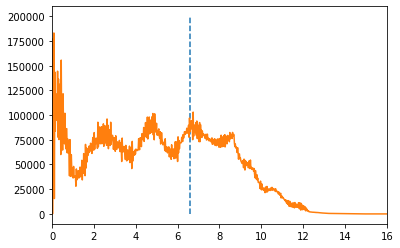

In [31]:
plt.xlim([0,16])

peak1=(2*np.pi/alat)*np.sqrt(2**2+2**2+1**2)

peaks=[
       [peak1,peak1],
       [4.378526346466611,4.378526346466611],
       [6.192171342380999,6.192171342380999],
       [7.583830094359099,7.583830094359099]
      ]
peak_2=[0,200000]

plt.plot(peaks[0],peak_2,'--')
#plt.plot(peaks[1],peak_2,'--')
#plt.plot(peaks[2],peak_2,'--')
#plt.plot(peaks[3],peak_2,'--')

plt.plot(q,Iq,'-')

### BCC supercell

In [1086]:
alat=2.87*2
hkl=6
N=40
pos_bcc=np.zeros((N,N,N))

# atoms at (0,0,0) and (a/2,a/2,a/2)
pos_bcc[0,0,0]=1.0
pos_bcc[int(N/2),0,0]=1.0
pos_bcc[0,int(N/2),0]=1.0
pos_bcc[int(N/2),int(N/2),0]=1.0
pos_bcc[N-1,0,0]=1.0
pos_bcc[0,N-1,0]=1.0
pos_bcc[int(N/2),N-1,0]=1.0
pos_bcc[N-1,int(N/2),0]=1.0
pos_bcc[N-1,N-1,0]=1.0

pos_bcc[int(N/4),int(N/4),int(N/4)]=1.0
pos_bcc[int(N*3/4),int(N/4),int(N/4)]=1.0
pos_bcc[int(N/4),int(N*3/4),int(N/4)]=1.0
pos_bcc[int(N*3/4),int(N*3/4),int(N/4)]=1.0

pos_bcc[0,0,int(N/2)]=1.0
pos_bcc[int(N/2),0,int(N/2)]=1.0
pos_bcc[0,int(N/2),int(N/2)]=1.0
pos_bcc[int(N/2),int(N/2),int(N/2)]=1.0
pos_bcc[N-1,0,int(N/2)]=1.0
pos_bcc[0,N-1,int(N/2)]=1.0
pos_bcc[int(N/2),N-1,int(N/2)]=1.0
pos_bcc[N-1,int(N/2),int(N/2)]=1.0
pos_bcc[N-1,N-1,int(N/2)]=1.0

pos_bcc[int(N/4),int(N/4),int(N*3/4)]=1.0
pos_bcc[int(N*3/4),int(N/4),int(N*3/4)]=1.0
pos_bcc[int(N/4),int(N*3/4),int(N*3/4)]=1.0
pos_bcc[int(N*3/4),int(N*3/4),int(N*3/4)]=1.0

pos_bcc[0,0,N-1]=1.0
pos_bcc[int(N/2),0,N-1]=1.0
pos_bcc[0,int(N/2),N-1]=1.0
pos_bcc[int(N/2),int(N/2),N-1]=1.0
pos_bcc[N-1,0,N-1]=1.0
pos_bcc[0,N-1,N-1]=1.0
pos_bcc[int(N/2),N-1,N-1]=1.0
pos_bcc[N-1,int(N/2),N-1]=1.0
pos_bcc[N-1,N-1,N-1]=1.0

print("number of atoms:",np.count_nonzero(pos_bcc))

Sq_bcc=fftn(pos_bcc)
Sq_bcc=np.absolute(Sq_bcc)

number of atoms: 35


In [1087]:
Sq_bcc_hkl=np.zeros((hkl*Sq_bcc.shape[0],hkl*Sq_bcc.shape[1],hkl*Sq_bcc.shape[2]))

for i in range(hkl):
    for j in range(hkl):
        for k in range(hkl):
            Sq_bcc_hkl[i*Sq_bcc.shape[0]:(i+1)*Sq_bcc.shape[0],
                       j*Sq_bcc.shape[1]:(j+1)*Sq_bcc.shape[1],
                       k*Sq_bcc.shape[2]:(k+1)*Sq_bcc.shape[2]] = Sq_bcc

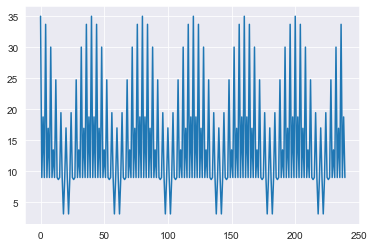

In [1088]:
plt.plot(range(N*hkl),Sq_bcc_hkl[:,0,0])

In [1089]:
Iq_bcc=[]
for i in trange(N*hkl-1):
    for j in range(N*hkl-1):
        for k in range(N*hkl-1):
            r0=np.sqrt(
              (2*np.pi/alat)*( ((i)/N)**2 + ((j)/N)**2 + ((k)/N)**2 )
            )
            r1=np.sqrt(
              (2*np.pi/alat)*( ((i+1)/N)**2 + ((j)/N)**2 + ((k)/N)**2 )
            )
            Iq_bcc.append([
                           r0, 
                           Sq_bcc_hkl[i,j,k]/(r1**3-r0**3)
                          ])
Iq_bcc=np.asarray(Iq_bcc)

In [1090]:
q=(2*np.pi/alat)*np.arange(0.0,hkl*np.sqrt(3),0.01)

Iq=np.zeros(q.shape[0])
for i in range(Iq_bcc.shape[0]):
    Iq[np.abs(q-Iq_bcc[i,0]).argmin()]+=Iq_bcc[i,1]

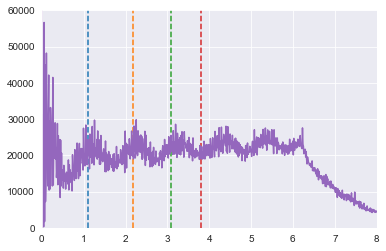

In [1092]:
plt.ylim([0,60000])
plt.xlim([0,8])

peaks=[
       [2*np.pi/alat*np.sqrt(1**2+0**2+0**2),2*np.pi/alat*np.sqrt(1**2+0**2+0**2)],
       [2*np.pi/alat*np.sqrt(2**2+0**2+0**2),2*np.pi/alat*np.sqrt(2**2+0**2+0**2)],
       [2*np.pi/alat*np.sqrt(2**2+2**2+0**2),2*np.pi/alat*np.sqrt(2**2+2**2+0**2)],
       [2*np.pi/alat*np.sqrt(2**2+2**2+2**2),2*np.pi/alat*np.sqrt(2**2+2**2+2**2)]
      ]
peak_2=[0,100000]

plt.plot(peaks[0],peak_2,'--')
plt.plot(peaks[1],peak_2,'--')
plt.plot(peaks[2],peak_2,'--')
plt.plot(peaks[3],peak_2,'--')

plt.plot(q,Iq/20)

Here, we note that the $S(q)$ has been changed because of the supercell environment. Note that the momentum $q$ has been a half compared to the unit-cell case, $\frac{2\pi}{a} \to \frac{2\pi}{2a}$

### BCC 2D

In [203]:
q=np.arange(0.0,1.0,0.01)
a=np.pi
N=101
pos_bcc=np.zeros((N,N))

# atoms at (0,0,0) and (a/2,a/2,a/2)
pos_bcc[0,0]=1.0
pos_bcc[int(N/4),N-5]=1.0

Sq_bcc=fftn(pos_bcc)
abs_Sq_bcc=np.absolute(Sq_bcc)

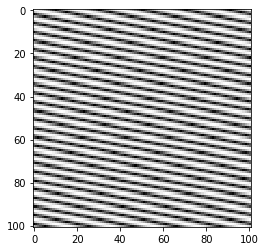

In [204]:
plt.imshow(abs_Sq_bcc, cmap=cm.gray)
plt.show()

## Structure factor (1)

In this section of code, I calculate the structure factor $S(q)$ by calculating 

$S(q)=\frac{1}{N} \sum_j^N \sum_k^N e^{-iq(R_j-R_k)}$.

In [922]:
atoms=read('./POSCAR')
natoms=atoms.positions.shape[0]
rcut=[1.0]*natoms
alat=2.87

In [923]:
list_atoms_positions=[]
list_loc_positions=[]
for i in range(natoms):
    indices, offsets = build_neighbor_list(atoms, cutoffs=rcut, bothways=False, self_interaction=True).get_neighbors(i)
    #positions of locals
    list_loc_positions+=[(atoms.positions[ii] + np.dot(offset, atoms.get_cell())).tolist() 
                        for ii, offset in zip(indices, offsets)]
    #positions of atoms
    list_atoms_positions+=[(atoms.positions[i]).tolist()
                          for ii, offset in zip(indices, offsets)]

#Ri-Rj
list_loc_positions=(np.array(list_loc_positions)-np.array(list_atoms_positions)).tolist()

In [924]:
list_loc_positions=list_loc_positions[:2]

[[0.0, 0.0, 0.0],
 [1.435, 1.435, 1.435],
 [0.0, 0.0, 0.0],
 [-1.435, -1.435, 1.435],
 [-1.435, 1.435, -1.435],
 [-1.435, 1.435, 1.435],
 [1.435, -1.435, -1.435],
 [1.435, -1.435, 1.435],
 [1.435, 1.435, -1.435],
 [1.435, 1.435, 1.435]]

In [925]:
ngrid=81
hkl=10
q0=np.linspace(0, hkl, ngrid)
qx,qy,qz=np.meshgrid(q0,q0,q0,indexing='ij')

In [926]:
Sq=[]
norm=len(list_loc_positions)

j=k=0
for i in tnrange(ngrid-1):
    for j in range(ngrid-1):
        for k in range(ngrid-1):
            Sq_q=0
            for loc in list_loc_positions:
                q=2*np.pi/alat*np.array([qx[i,j,k], qy[i,j,k], qz[i,j,k]])
                q1=2*np.pi/alat*np.array([qx[i+1,j,k], qy[i,j,k], qz[i,j,k]])
                delq=(4/3)*np.pi*np.abs(LA.norm(q1)**3-LA.norm(q)**3)

                rq=np.dot(q,np.array(loc))
                Sq_q+=np.exp(-1j * rq).real/norm/delq
            Sq+=[[LA.norm(q),Sq_q]]
Sq=np.array(Sq)

/Users/cwmyung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


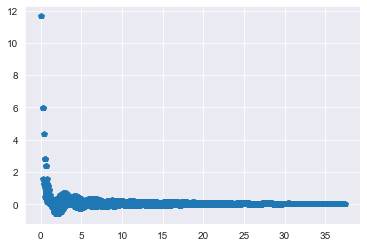

In [927]:
plt.plot(Sq[:,0],Sq[:,1],'p')

In [928]:
q=(2*np.pi/alat)*np.arange(0.0,hkl*np.sqrt(3),0.01)
Sqq=np.zeros(q.shape[0])
for i in range(Sq.shape[0]-1):
    j=np.abs(q-Sq[i,0]).argmin()
    Sqq[j]+=Sq[i,1]

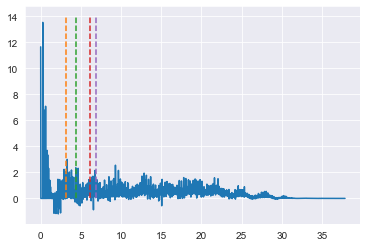

In [929]:
peaks=[
       [3.0960856711904996,3.0960856711904996],
       [4.378526346466611,4.378526346466611],
       [6.192171342380999,6.192171342380999],
       [6.923058024945019,6.923058024945019]
      ]
peak_2=[0,14]

plt.plot(q[:-2],Sqq[:-2],'-')
plt.plot(peaks[0],peak1_2,'--')
plt.plot(peaks[1],peak1_2,'--')
plt.plot(peaks[2],peak1_2,'--')
plt.plot(peaks[3],peak1_2,'--')

In [897]:
(2*np.pi/alat)*np.sqrt(10)

6.923058024945019

## Structure factor (2)

Here, instead of calculating the intensity, I calculate a complex function $\psi(q)=\sum_j^N e^{-iqR_j}$ and calculate the strucuture factor by $\frac{1}{N} \psi(q)\psi^*(q)$.

In [930]:
atoms=read('./SPOSCAR')
list_atoms_positions=atoms.positions

In [932]:
ngrid=81
hkl=10
q0=np.linspace(0, hkl, ngrid)
qx,qy,qz=np.meshgrid(q0,q0,q0,indexing='ij')

Calcuate $\psi(q)=\sum_j^N e^{-i q R_j}$

In [933]:
psiq=[]
for i in tnrange(ngrid-1):
    for j in range(ngrid-1):
        for k in range(ngrid-1):
            psi_q=0
            for loc in list_atoms_positions:
                q=2*np.pi/alat*np.array([qx[i,j,k], qy[i,j,k], qz[i,j,k]])
                q1=2*np.pi/alat*np.array([qx[i+1,j,k], qy[i,j,k], qz[i,j,k]])
                delq=(4/3)*np.pi*np.abs(LA.norm(q1)**3-LA.norm(q)**3)
                
                rq=np.dot(q,np.array(loc))
                psi_q+=np.exp(-1j * rq)/delq
            psiq+=[[LA.norm(q),psi_q]]

/Users/cwmyung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [934]:
psiq=np.absolute(psiq)

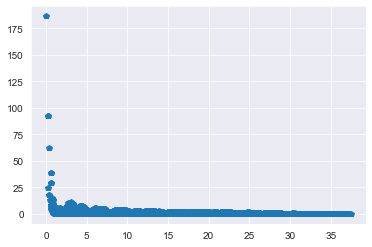

In [935]:
plt.plot(psiq[:,0],psiq[:,1],'p')

In [936]:
q=(2*np.pi/alat)*np.arange(0.0,hkl*np.sqrt(3),0.01)
psiqq=np.zeros(q.shape[0])
for i in range(psiq.shape[0]-1):
    j=np.abs(q-psiq[i,0]).argmin()
    psiqq[j]+=psiq[i,1]

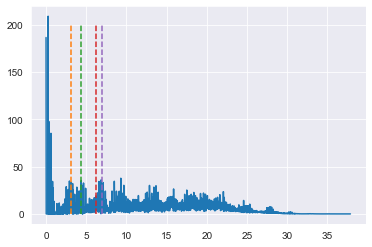

In [940]:
peaks=[
       [3.0960856711904996,3.0960856711904996],
       [4.378526346466611,4.378526346466611],
       [6.192171342380999,6.192171342380999],
       [6.923058024945019,6.923058024945019]
      ]
peak_2=[0,200]

plt.plot(q[:-2],psiqq[:-2],'-')
plt.plot(peaks[0],peak_2,'--')
plt.plot(peaks[1],peak_2,'--')
plt.plot(peaks[2],peak_2,'--')
plt.plot(peaks[3],peak_2,'--')